# **N&L Framework: Time and Income Scenario**

This interactive notebook illustrates possible applications of the Needs & Limits (N&L) framework to the topics of income inequality and climate policy.

**Scenario Overview**

![Scenario Overview](overview.png)

## Settings

In [1]:
# Automatic reload
%reload_ext autoreload
%autoreload 2

# Time and Income Scenario
from model import Model
import calibration
import plots

# Other dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import agentpy as ap
import pandas as pd
import numpy as np
import cProfile
import datetime

In [2]:
# Calibration
PROFILE = False
CALIBRATE = False
TEST_CAL = False

# Simulation
RUN = False
PLOT = True
ITERATIONS = 20
RESOLUTION = 20

# Experiments
GROWTH_REDIST = True
CARBON_TAX = True
MULTIPLIER = True

## Parameters

In [3]:
parameters = {
    # Base parameters
    'agents': 100,  
    'steps': 3,
    'seed': 0,
    'income': 100,
    'network_neighbors': 2,
    'network_randomness': 0.1, 
    'domain_substitution': 0.01,
    
    # Experiment levers
    'growth': 0,
    'redist': 0,
    'ctax': 0,
    'ctax_redist': 0,
    'imp_norms': 1.0,
    'imp_norms_recreation': 1.0,
}

## Calibration & Profiling

In [12]:
if CALIBRATE or TEST_CAL:
    n_samples = 10
    n_cal_vars = 6
    load_x0 = True
    save_cal_vars = True
    tolerance = 0.001
    cal_data = np.loadtxt(f'data/cantril_dist.txt', dtype=int)

In [13]:
if CALIBRATE:
    x0 = np.loadtxt(f'data/cal_vars.txt') if load_x0 else np.ones(n_cal_vars)
    res = calibration.calibrate_model(
        Model, parameters, x0, cal_data, 
        n_samples=n_samples, xtol=tolerance)
    if save_cal_vars:
        np.savetxt(f'data/cal_vars.txt', res.x)

In [14]:
if TEST_CAL:
    calibration.test_calibration(Model, parameters, cal_data, n_samples)

In [ ]:
if False:
    cProfile.run('results = Model(parameters).run()', sort=2)

## Experiment 1: Agent distributions

In [6]:
params = {**parameters}
model = Model(params)
results = model.run()

Completed: 3 steps
Run time: 0:00:02.812654
Simulation finished
Expected results: True


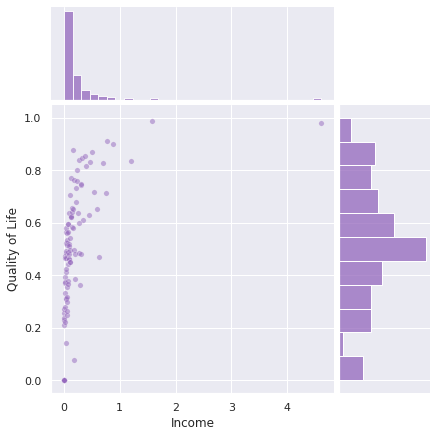

In [111]:
# Agent distribution (QOL)
plots.qol_income_dist(results, 'qol', 'Quality of Life', color='tab:purple')
plt.savefig('plots/qol_income_dist.pdf', bbox_inches='tight')

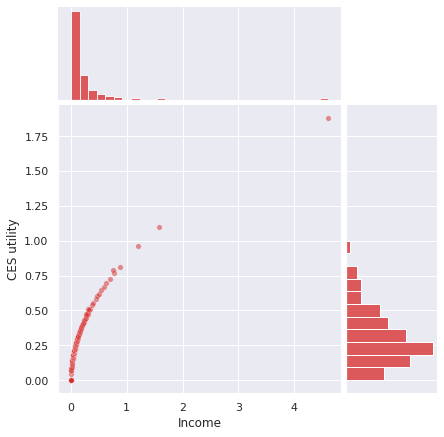

In [12]:
# Agent distribution (CES)
plots.qol_income_dist(results, 'ces', 'CES utility', color='tab:red')
plt.savefig('plots/ces_income_dist.pdf', bbox_inches='tight')

## Experiment 2: Growth & Redistribution 

In [11]:
if GROWTH_REDIST and RUN:
    ranges = {
        'growth': ap.Range(0, 10),
        'redist': ap.Range(0, 1)
    }
    for key, p_range in ranges.items(): 
        params = {**parameters, key: p_range}
        sample = ap.Sample(params, n=RESOLUTION, randomize=False)
        exp = ap.Experiment(Model, sample, iterations=ITERATIONS)
        res = exp.run()
        res.save(key, 0, 'results')

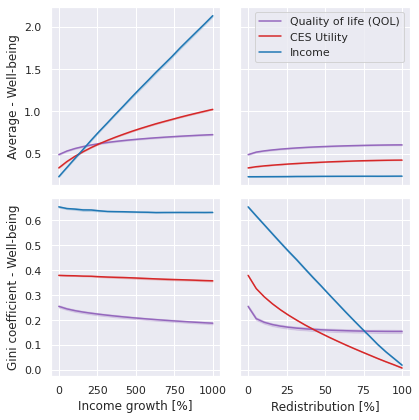

In [15]:
if GROWTH_REDIST and PLOT:
    plots.growth_redist()
    plt.savefig(f"plots/growth_redist.pdf", bbox_inches='tight')

## Experiment 3: Carbon pricing

In [13]:
if CARBON_TAX and RUN:
    params = {
        **parameters,
        'ctax': ap.Range(0, 1),
        'ctax_redist': ap.Values(0, 0.1, 0.2, 0.3),
    }
    sample = ap.Sample(params, n=RESOLUTION, randomize=False)
    exp = ap.Experiment(Model, sample, iterations=ITERATIONS)
    results = exp.run()
    results.save('ctax', 0, 'results')

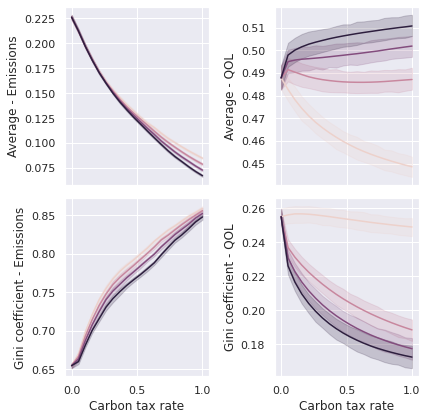

In [16]:
if CARBON_TAX and PLOT:
    plots.carbon_tax()
    plt.savefig('plots/ctax_EQ.pdf', bbox_inches='tight')

## Experiment 4: Social multiplier

In [16]:
if MULTIPLIER and RUN: 
    params = {
        **parameters,
        'ctax': 1,
        'imp_norms': ap.Range(0.001, 5),
        'imp_norms_recreation': ap.Values(0, 0.25, 0.5, 0.75, 1)
    }
    sample = ap.Sample(params, n=RESOLUTION, randomize=False)
    exp = ap.Experiment(Model, sample, iterations=ITERATIONS)
    results = exp.run()
    results.save('multiplier', 0, 'results')

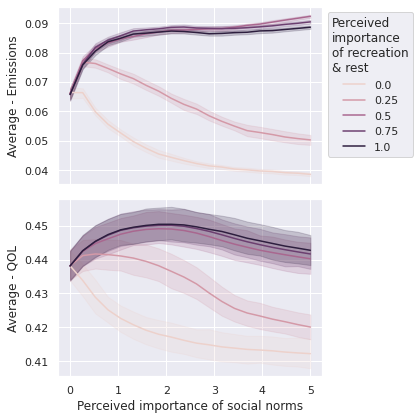

In [19]:
if MULTIPLIER and PLOT:
    plots.multiplier()
    plt.savefig('plots/multiplier.pdf', bbox_inches='tight')